In [1]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
from jupyter_dash import JupyterDash

In [2]:
df = pd.read_csv('scada_thanhhoa.csv')
df['time'] = pd.to_datetime(df['ts'], unit='s')
df = df.query('parameter_key == "P" or parameter_key == "PS1"')
df = df.filter(['deviceid', 'time', 'parameter_key', 'dbl_v'])
list_device = df['deviceid'].unique().tolist()

app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Time Series Plot of dbl_v over Time"),
    dcc.Dropdown(
        id='device-dropdown',
        options=[{'label': device, 'value': device} for device in list_device],
        value=list_device[0],  # Thiết lập giá trị mặc định
        clearable=False
    ),
    dcc.Graph(
    id='time-series-plot',
    style={'width': '100vw', 'height': '100vh'}  # Điều chỉnh kích thước theo mong muốn
)
])
@app.callback(
    Output('time-series-plot', 'figure'),
    [Input('device-dropdown', 'value')]
)
def update_graph(selected_device):
    filtered_df = df[df['deviceid'] == selected_device]
    fig = px.line(filtered_df, x='time', y='dbl_v', markers=True, title=f'Time Series Plot for Device {selected_device}')
    fig.update_layout(
        xaxis_title='time',
        yaxis_title='dbl_v',
        xaxis=dict(
            tickformat='%Y-%m-%d %H:%M:%S',
            tickangle=-45
        )
    )
    return fig
port_number = 1247
app.run_server(mode='inline', port=port_number, debug=True)

C:\Users\phamv\AppData\Local\Temp\ipykernel_28508\1077678925.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('scada_thanhhoa.csv')
c:\Users\phamv\AppData\Local\Programs\Python\Python312\Lib\site-packages\dash\dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



#### **Đánh giá**

Đánh giá sơ bộ về đường xu hướng áp lực nước của các thiết bị: Đường xu hướng không thực sự rõ ràng, áp lực nước của các thiết bị liên tục có những sự thay đổi lớn trong một khoảng thời gian ngắn (vài giây)

#### **Áp dụng KHDL**

##### **Dự báo áp lực nước với mô hình ARIMA**

In [88]:
df = pd.read_csv('scada_thanhhoa.csv')
df['time'] = pd.to_datetime(df['ts'], unit='s')
#df = df.query('deviced == ""')
df = df.query('parameter_key == "P"')
df['deviceid'].unique()

array(['66d92f94b7f41dd37df0634a', '66d92fabb7f41dd37df06351',
       '66d92fc2b7f41dd37df06355', '66d92fc6b7f41dd37df06359',
       '66d92fcbb7f41dd37df0635d', '66d92fcfb7f41dd37df06361'],
      dtype=object)

In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
import plotly.graph_objects as go
import pandas as pd

warnings.filterwarnings("ignore")

In [6]:

df = pd.read_csv('scada_thanhhoa.csv')
df['time'] = pd.to_datetime(df['ts'], unit='s')
df = df.query('parameter_key == "P" or parameter_key == "PS1"')
df = df.filter(['time', 'parameter_key', 'dbl_v'])

df_p = df[df['parameter_key'] == 'P'].set_index('time')
df_p = df_p['dbl_v'].resample('H').mean().dropna()  # Resample theo giờ và tính giá trị trung bình

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("Chuỗi không có tính dừng.")
    else:
        print("Chuỗi có tính dừng.")

test_stationarity(df_p)

stepwise_model = auto_arima(df_p, start_p=1, start_q=1,
                            max_p=5, max_q=5, seasonal=False,
                            d=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

model = ARIMA(df_p, order=stepwise_model.order)
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=24)
forecast_index = pd.date_range(start=df_p.index[-1], periods=24, freq='H')
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_p.index, y=df_p, mode='lines', name='Actual data'))

fig.add_trace(go.Scatter(x=forecast_index, y=forecast_values, mode='lines', name='Forecast', line=dict(color='red')))

fig.add_trace(go.Scatter(
    x=forecast_index.tolist() + forecast_index[::-1].tolist(),
    y=conf_int['lower dbl_v'].tolist() + conf_int['upper dbl_v'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.3)',
    line_color='rgba(255, 182, 193, 0)',
    showlegend=False,
    name='Confidence Interval'
))

fig.update_layout(
    title='ARIMA Forecast for Water Pressure (P)',
    xaxis_title='Time',
    yaxis_title='Pressure (dbl_v)',
    legend=dict(x=0, y=1),
    hovermode='x'
)
fig.show()


ADF Statistic: -2.468537397915798
p-value: 0.12331836632722559
Chuỗi không có tính dừng.
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-673.683, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-642.080, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-675.491, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-670.694, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-644.053, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-673.714, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-671.597, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-677.480, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-675.703, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-675.673, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-672.678, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-673.586, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.388 seconds

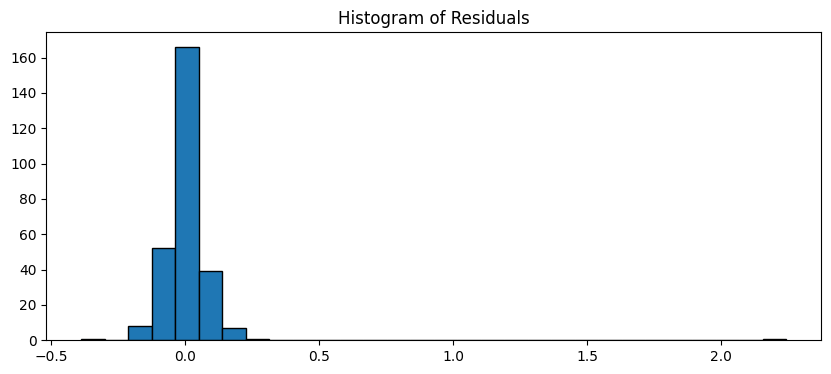

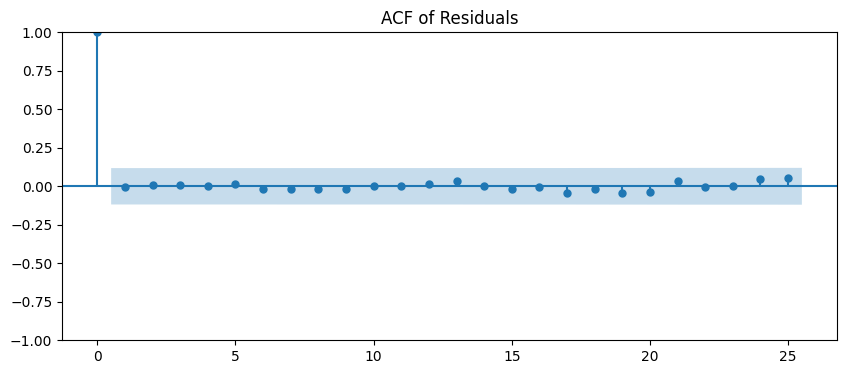

Mean of Residuals: 0.008612467857152827
Variance of Residuals: 0.023062163915522616


In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Lấy phần dư từ mô hình ARIMA
residuals = model_fit.resid

plt.figure(figsize=(10, 4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
sm.graphics.tsa.plot_acf(residuals, ax=ax)
plt.title('ACF of Residuals')
plt.show()

mean_residual = np.mean(residuals)
variance_residual = np.var(residuals)
print(f"Mean of Residuals: {mean_residual}")
print(f"Variance of Residuals: {variance_residual}")


#### **Đánh giá**

Dựa trên kết quả:
- **Mean of Residuals (Giá trị trung bình của phần dư)**: 0.0086, rất gần với 0. Điều này cho thấy rằng mô hình ARIMA không có sai số dự báo lệch, nghĩa là các dự báo không có xu hướng hệ thống bị lệch về một phía (quá cao hoặc quá thấp).
  
- **Variance of Residuals (Phương sai của phần dư)**: 0.023, tương đối nhỏ. Điều này cho thấy sự phân tán của các phần dư không quá lớn, cho thấy mô hình ARIMA khá tốt trong việc dự đoán dữ liệu.
#### Đánh giá:
- Histogram của residuals cho thấy rằng phần lớn các giá trị residuals đều tập trung gần 0, điều này là tốt vì nó cho thấy mô hình ARIMA đã dự báo khá chính xác với phần dư nhỏ. Tuy nhiên, vẫn có một vài giá trị outliers với residuals xa hơn khỏi giá trị trung bình.
- Phần dư có giá trị trung bình gần bằng 0 và phương sai nhỏ là dấu hiệu cho thấy mô hình ARIMA hoạt động khá tốt.Mô hình ARIMA có thể được coi là phù hợp.
- Biểu đồ ACF của Residuals mà bạn cung cấp cho thấy rằng tất cả các giá trị tự tương quan của residuals đều nằm trong khoảng tin cậy (confidence interval) và gần 0, ngoại trừ giá trị lag = 0. Mô hình ARIMA của dường như hoạt động tốt, vì các residuals không có tự tương quan, điều này cho thấy rằng mô hình đã dự đoán chính xác và không bỏ sót các mẫu có thể dự đoán được.

##### **Dự báo ngoại lệ với IsolationForest**

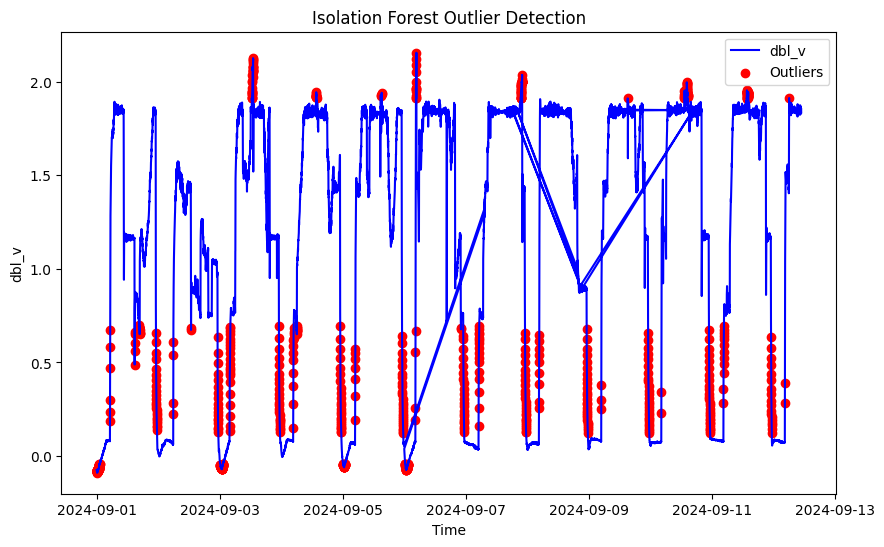

In [77]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

df = pd.read_csv('scada_thanhhoa.csv')
df['time'] = pd.to_datetime(df['ts'], unit='s')
df = df.query('parameter_key == "P" or parameter_key == "PS1"')
df = df.query('deviceid == "66d92fcfb7f41dd37df06361"')
df = df.filter(['deviceid', 'time', 'dbl_v'])

df_p = df[['dbl_v']]

model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(df_p)

df['anomaly'] = df['anomaly'].apply(lambda x: 'outlier' if x == -1 else 'normal')

plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['dbl_v'], label='dbl_v', color='blue')
plt.scatter(df[df['anomaly'] == 'outlier']['time'], df[df['anomaly'] == 'outlier']['dbl_v'], color='red', label='Outliers')
plt.xlabel('Time')
plt.ylabel('dbl_v')
plt.title('Isolation Forest Outlier Detection')
plt.legend()
plt.show()


In [79]:
# Đánh giá
# Kiểm tra tỷ lệ phần trăm các điểm ngoại lệ trong tập dữ liệu
outlier_percentage = len(df[df['anomaly'] == 'outlier']) / len(df) * 100
print(f"Tỷ lệ ngoại lệ được phát hiện: {outlier_percentage}%")


Tỷ lệ ngoại lệ được phát hiện: 4.990600933842702%


**Kết luận:** Khả năng áp dụng KHDL vào trong việc phân tích, dự báo, dự đoán áp lực nước là hoàn toàn khả thi, tuy nhiên để cải thiện kết quả, cần có dữ liệu dài hạn hơn, khi đó những biến động về chỉ số được rõ ràng và có thể áp dụng cải thiện được kết quả khi dự báo dự đoán